<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imporitng-Required-Packages" data-toc-modified-id="Imporitng-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imporitng Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#ARMA(1,-1)-Model" data-toc-modified-id="ARMA(1,-1)-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ARMA(1, 1) Model</a></span></li><li><span><a href="#Modeling-ARMA(1,-1)-Residuals" data-toc-modified-id="Modeling-ARMA(1,-1)-Residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling ARMA(1, 1) Residuals</a></span><ul class="toc-item"><li><span><a href="#GARCH-Model" data-toc-modified-id="GARCH-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>GARCH Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Lags" data-toc-modified-id="Estimating-Lags-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Estimating Lags</a></span></li><li><span><a href="#GARCH(2,-2)-Model" data-toc-modified-id="GARCH(2,-2)-Model-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>GARCH(2, 2) Model</a></span></li></ul></li></ul></li><li><span><a href="#ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model" data-toc-modified-id="ARMA(1,-1)-(Predictions)---GARCH(2,-2)-(Confidence-Levels)-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model</a></span></li></ul></div>

# Imporitng Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from sklearn.metrics import mean_squared_error

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [2]:
file_path = "../data.csv"

In [3]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
data = data_backup[["spx_ret", "spx_vol"]]

# Train Test Split

In [5]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

# ARMA(1, 1) Model

**Building the Model**

In [6]:
arma_model = SARIMAX(train_df["spx_ret"][1:], order = (1, 0, 1))
arma_model_results = arma_model.fit()
arma_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                spx_ret   No. Observations:                 6517
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -10024.948
Date:                Thu, 01 Oct 2020   AIC                          20055.897
Time:                        19:23:23   BIC                          20076.243
Sample:                    01-07-1994   HQIC                         20062.933
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6462      0.047     13.689      0.000       0.554       0.739
ma.L1         -0.7075      0.043    -16.560      0.000      -0.791      -0.624
sigma2         1.2696      0.010    128.105      0.000       1.250       1.289
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             20322.56
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Setting the Prediction Interval.**

In [7]:
start_date, end_date = test_df.index[0], test_df.index[-1]

**Predictions**

In [8]:
arma_forecast = arma_model_results.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05) # Confidence level of 95%
arma_predictions_df["Predictions"] = arma_model_results.predict(start = start_date, end = end_date)

**Plot of Predicted vs Actual Values**

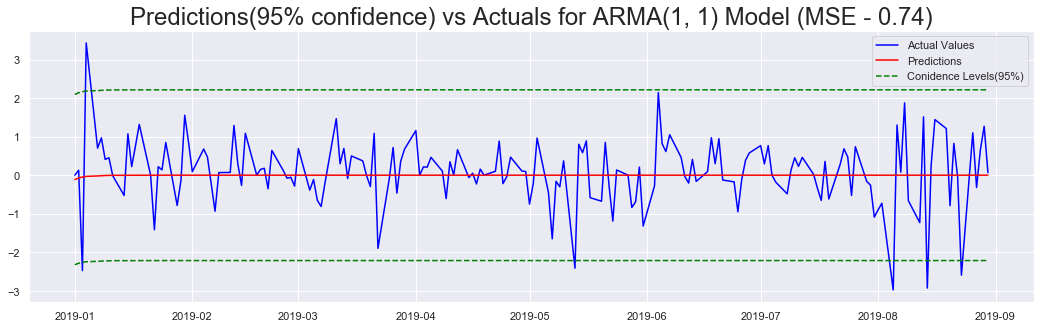

In [9]:
arma_mse = mean_squared_error(test_df["spx_ret"].values, arma_predictions_df["Predictions"])

plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["spx_ret"][start_date:end_date], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"][start_date:end_date], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper spx_ret"][start_date:end_date], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(arma_predictions_df["lower spx_ret"][start_date:end_date], color = "green", linestyle = "--")

plt.title(f"Predictions(95% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {round(arma_mse, 2)})", size = 24)

plt.legend()
plt.show()

# Modeling ARMA(1, 1) Residuals

In [10]:
resid_df = data.copy()
resid_df["spx_ret_resid"] = resid_df["spx_ret"]
resid_df.at[train_df.index[1]:train_df.index[-1], "spx_ret_resid"] = arma_model_results.resid

Plotting **Residuals** of **ARMA(1, 1)** Model

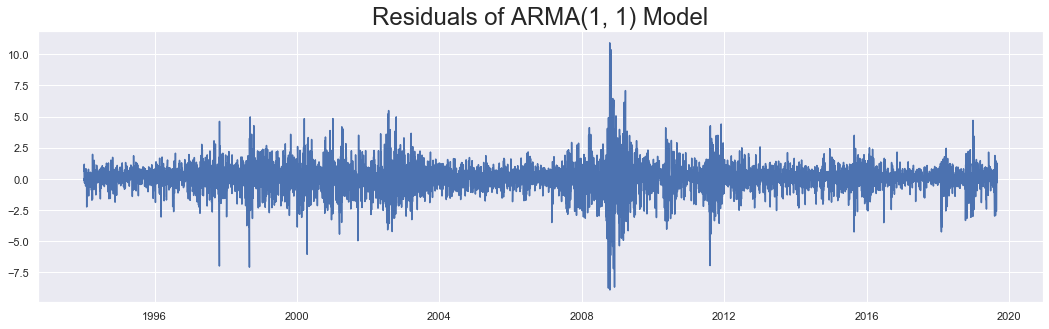

In [11]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(resid_df["spx_ret_resid"][1:])
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Through this plot, it is obvious that the variance varies with time and hence modeling this with a **GARCH** model may be reasonable. 

## GARCH Model

### Estimating Lags

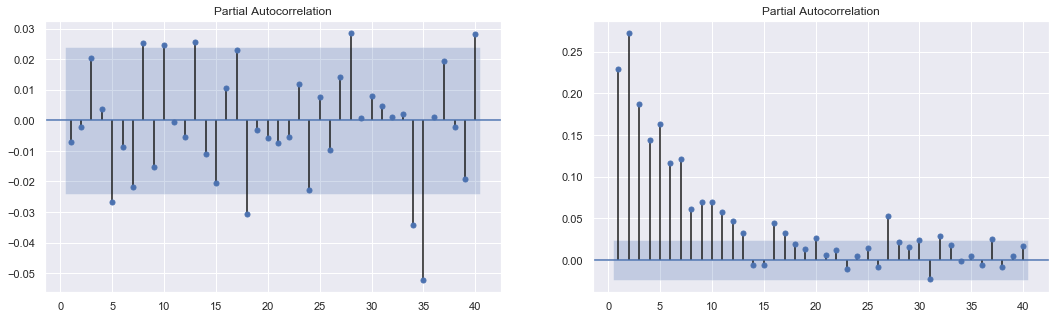

In [12]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_pacf(resid_df.spx_ret_resid[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(resid_df.spx_ret_resid[1:].abs(), zero = False, lags = 40, ax = axes[1])

plt.show()

Since, the first 2 lags for magnitude of returns are strongly significant and the significance level sharply drops later, we will use a **GARCH(2, 2)** Model for modeling residuals of ARMA(1, 1) on SPX Returns.

### GARCH(2, 2) Model

**Building the Model**

**Note**: In some cases, the model may fail to converge. In such case, running the code cell below will most likely fix the issue. However, one can also follow the approach given [here](https://quant.stackexchange.com/questions/32350/fitting-garch1-1-in-python-for-moderately-large-data-sets) for a more robust solution.

In [21]:
garch_model = arch_model(resid_df["spx_ret_resid"][1:], p = 2, q = 2, mean = "Constant", vol = "GARCH")
garch_model_results = garch_model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     53,   Neg. LLF: 8624.406736573577
Iteration:     10,   Func. Count:    100,   Neg. LLF: 8621.036684301598
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8620.971399827009
            Iterations: 14
            Function evaluations: 133
            Gradient evaluations: 14


In [22]:
garch_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:          spx_ret_resid   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -8620.97
Distribution:                  Normal   AIC:                           17253.9
Method:            Maximum Likelihood   BIC:                           17294.6
                                        No. Observations:                 6517
Date:                Thu, Oct 01 2020   Df Residuals:                     6511
Time:                        19:28:14   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0761  9.927e-03      7.665  1.794e-14 [5.663e-02,9.555e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0255  6.713e-03      3.806  1.415e-04 [1.239e-02,3.870e-02]
alpha[1]       0.0587  1.611e-02      3.643  2.695e-04 [2.711e-02,9.024e-02]
alpha[2]       0.0987  2.147e-02      4.596  4.298e-06   [5.661e-02,  0.141]
beta[1]        0.3051      0.139      2.190  2.852e-02   [3.205e-02,  0.578]
beta[2]        0.5174      0.129      4.026  5.671e-05     [  0.266,  0.769]
============================================================================

Covariance estimator: robust
"""

**Predictions**

In [23]:
garch_predictions = garch_model_results.forecast(horizon = 1, align = "target")

**Plotting the Predictions**

In [24]:
garch_predictions_df = resid_df.copy()
garch_predictions_df["Predictions"] = garch_predictions.residual_variance[test_df.index[0]:test_df.index[-1]]

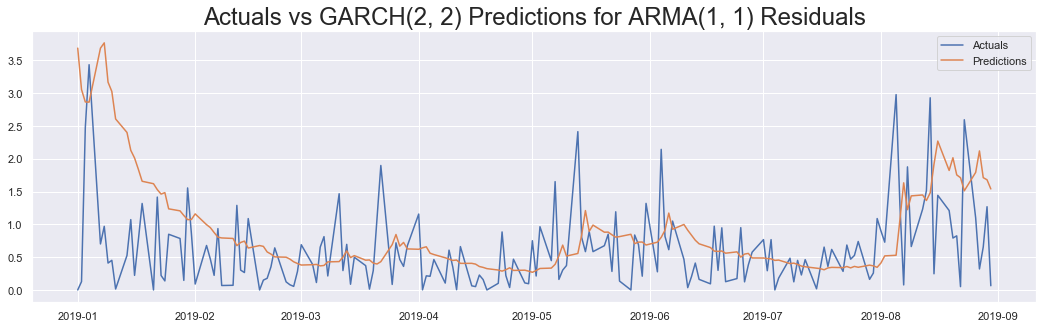

In [25]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(garch_predictions_df["spx_ret_resid"][test_df.index[0]:test_df.index[-1]].abs(), label = "Actuals")
plt.plot(garch_predictions_df["Predictions"], label = "Predictions")

plt.title("Actuals vs GARCH(2, 2) Predictions for ARMA(1, 1) Residuals", size = 24)

plt.legend()
plt.show()

# ARMA(1, 1) (Predictions) - GARCH(2, 2) (Confidence Levels) Model

In [26]:
final_predictions_df = pd.DataFrame(columns = ["spx_ret", "Predictions", "lower_bound", "upper_bound"])
final_predictions_df["spx_ret"] = test_df["spx_ret"]
final_predictions_df["Predictions"] = arma_predictions_df["Predictions"]
final_predictions_df["lower_bound"] = arma_predictions_df["Predictions"] - garch_predictions_df["Predictions"]
final_predictions_df["upper_bound"] = arma_predictions_df["Predictions"] + garch_predictions_df["Predictions"]

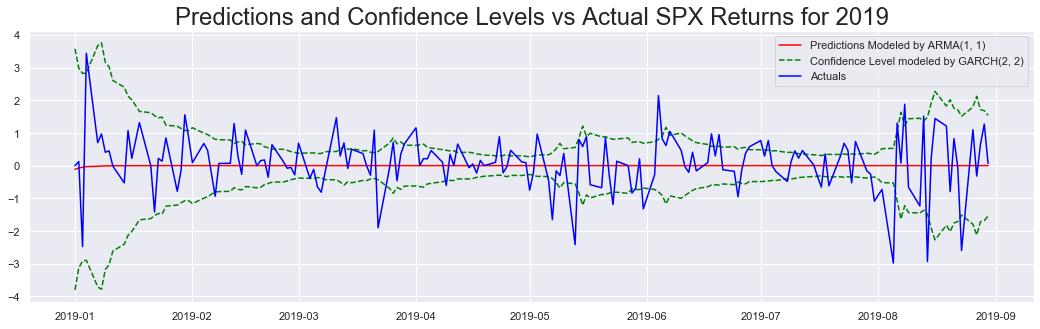

In [27]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(final_predictions_df["Predictions"], color = "red", label = "Predictions Modeled by ARMA(1, 1)")
plt.plot(final_predictions_df["lower_bound"], color = "green", linestyle = "--", label = "Confidence Level modeled by GARCH(2, 2)")
plt.plot(final_predictions_df["upper_bound"], color = "green", linestyle = "--")
plt.plot(final_predictions_df["spx_ret"], color = "blue", label = "Actuals")

plt.title("Predictions and Confidence Levels vs Actual SPX Returns for 2019", size = 24)

plt.legend()
plt.show()

As observed, these new confidence levels produced after modeling residulas of ARMA(1, 1) by GARCH(1, 1) give much more realisitic confidence levels. In majority of the cases the actual returns lie inside the confidence intervals. In the few handful cases where the predictions are not in the interval, only in a couple of cases, we have drastic errors. Otherwise, generally the errors are close to the upper/lower bounds.